<a href="https://colab.research.google.com/github/carlosperez1997/TFM_FlightDelayPrediction/blob/main/cancellations_diversions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis (Cancellation and Diversions)

**TFM - Title:** Study of flight delay in airports using Machine Learning techniques

**Developed by:** PÉREZ RICARDO, Carlos 

**Professors:** LORDAN GONZALEZ, Oriol; SALLAN LEYES, Jose Maria

**Date:** April 26th, 2022 


In [ ]:
def date_features(df, col):
    df[col] = pd.to_datetime(df[col])
    df['month'] = df[col].dt.month
    df['day'] = df[col].dt.day
    df['year'] = df[col].dt.year
    df['FL_DATE_quarter'] = df['FL_DATE'].dt.quarter
    df['weekday'] = df[col].dt.weekday
    df['year_month'] = [ str(y)+'_'+str(m) if m < 10 else str(y)+'_0'+str(m) for y, m in zip(df['year'], df['month']) ]
    df['year_week'] = df[col].dt.strftime('%Y%V')

    return df

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        try:
            if col_type != object:
                
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')
        except:
            pass
            
    end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Basics
import pandas as pd
import numpy as np
import time
import os
from os import listdir
from os.path import isfile, join, basename
from tqdm import tqdm
from timeit import timeit
import gc
from sys import getsizeof

import math
import sys
import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

In [ ]:
DIR = '/Users/carlosperezricardo/Desktop/TFM'
DIR = '/content/drive/MyDrive/TFM'

AIRPORT = 10397
years_to_load = ['2017','2018','2019']

Importing dataset

In [ ]:
folder = os.path.join(DIR, 'datasets')
files = [f for f in listdir(folder) if isfile(join(folder, f))]
files = sorted(files)

In [ ]:
if os.path.exists(os.path.join(DIR, 'df_all.pkl')):
    df = pd.read_pickle(os.path.join(DIR, 'df_all.pkl'))
else:
    df = pd.DataFrame()
    for file in files:
        loading = []
        if '.zip' in file:
            for year in years_to_load:
                loading.append(year in file)
            output = any(loading)
            if output:
                add_df = pd.read_csv(os.path.join(DIR,'datasets',file), parse_dates=['FL_DATE'])
                add_df = pd.read_csv(os.path.join(DIR,'datasets',file))
                add_df = reduce_mem_usage(add_df)
                df = pd.concat([df, add_df], axis=0)
                del add_df
    df.reset_index(drop=True, inplace=True)
    del df['Unnamed: 29']
    df.to_pickle(os.path.join(DIR, 'df_all.pkl'))

In [ ]:
df.head()

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,...,DEP_DELAY,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY
0,2017-01-01,AA,19805,AA,N3GNAA,2186,14100,1410002,34100,PHL,...,-5.0,731.0,-19.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
1,2017-01-01,AA,19805,AA,N3KAAA,2189,11298,1129804,30194,DFW,...,2.0,2023.0,-4.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2,2017-01-01,AA,19805,AA,N3LFAA,2190,11298,1129804,30194,DFW,...,0.0,4.0,16.0,0.0,NaN,0.0,0.0,0.0,16.0,0.0
3,2017-01-01,AA,19805,AA,N3DDAA,2191,11697,1169704,32467,FLL,...,-2.0,1528.0,-10.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
4,2017-01-01,AA,19805,AA,N3HLAA,2192,11278,1127803,30852,DCA,...,2.0,2052.0,12.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN


In [ ]:
df.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER',
       'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY'],
      dtype='object')

In [ ]:
df = date_features(df, 'FL_DATE')

In [ ]:
df = reduce_mem_usage(df)

# Cancellations and Diversions

In [ ]:
df.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER',
       'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY', 'month', 'day',
       'year', 'FL_DATE_quarter', 'weekday', 'year_month', 'year_week'],
      dtype='object')

In [ ]:
df['CANCELLED'].value_counts(dropna=False, normalize=True)*100

0.0    98.354504
1.0     1.645496
Name: CANCELLED, dtype: float64

In [ ]:
df['DIVERTED'].value_counts(dropna=False, normalize=True)*100

0.0    99.757416
1.0     0.242584
Name: DIVERTED, dtype: float64

In [ ]:
cancelled_df = df[df.CANCELLED == 1]
cancelled_df.shape

(334202, 36)

In [ ]:
diverted_df = df[df.DIVERTED == 1]
diverted_df.shape

(49269, 36)

## Airline 

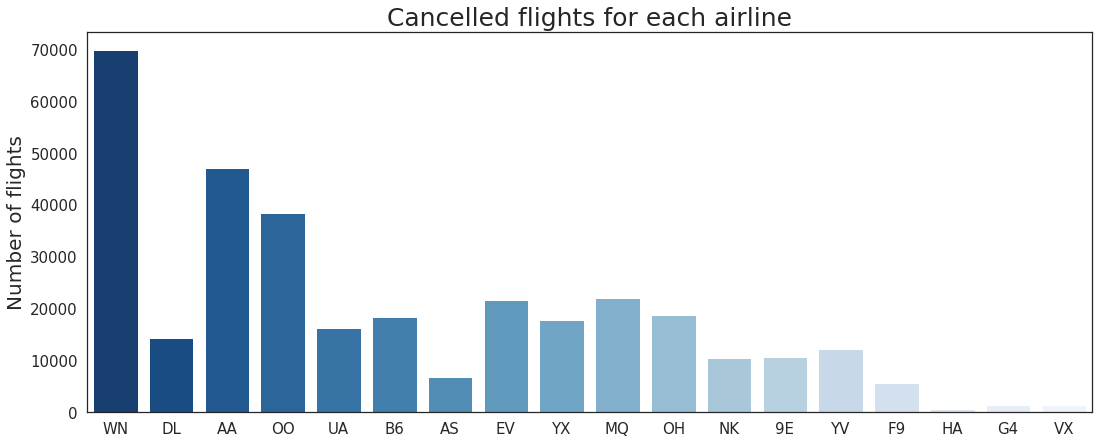

In [ ]:
rcParams['figure.figsize'] = 18,7
sns.set(style='white', rc={"grid.linewidth": 0.1})

ax = sns.countplot(x="OP_UNIQUE_CARRIER", data=cancelled_df, palette = "Blues_r", order = df['OP_UNIQUE_CARRIER'].value_counts().index)
ax.axes.set_title("Cancelled flights for each airline",fontsize=25)
ax.set_xlabel("")
ax.set_ylabel("Number of flights",fontsize=20)
ax.tick_params(labelsize=15)

plt.savefig('canc_airline.png')

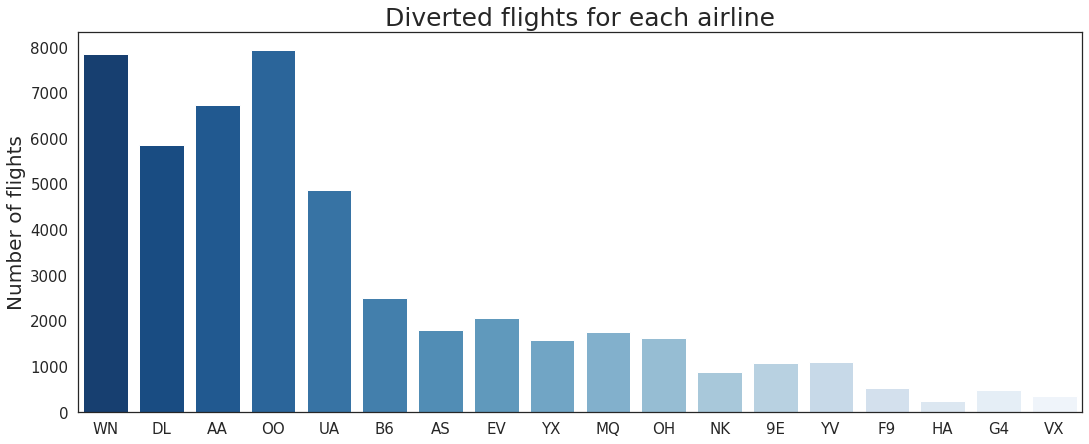

In [ ]:
rcParams['figure.figsize'] = 18,7
sns.set(style='white', rc={"grid.linewidth": 0.1})

ax = sns.countplot(x="OP_UNIQUE_CARRIER", data=diverted_df, palette = "Blues_r", order = df['OP_UNIQUE_CARRIER'].value_counts().index)
ax.axes.set_title("Diverted flights for each airline",fontsize=25)
ax.set_xlabel("")
ax.set_ylabel("Number of flights",fontsize=20)
ax.tick_params(labelsize=15)

plt.savefig('div_airline.png')

 ## Airport

In [ ]:
dest_vc = df['DEST'].value_counts().to_frame()
dest_vc = dest_vc.sort_values('DEST',ascending=False)
dest_vc.reset_index(inplace=True)
dest_vc['index'] = dest_vc['index'].astype('string')
dest_vc = dest_vc.head(25)

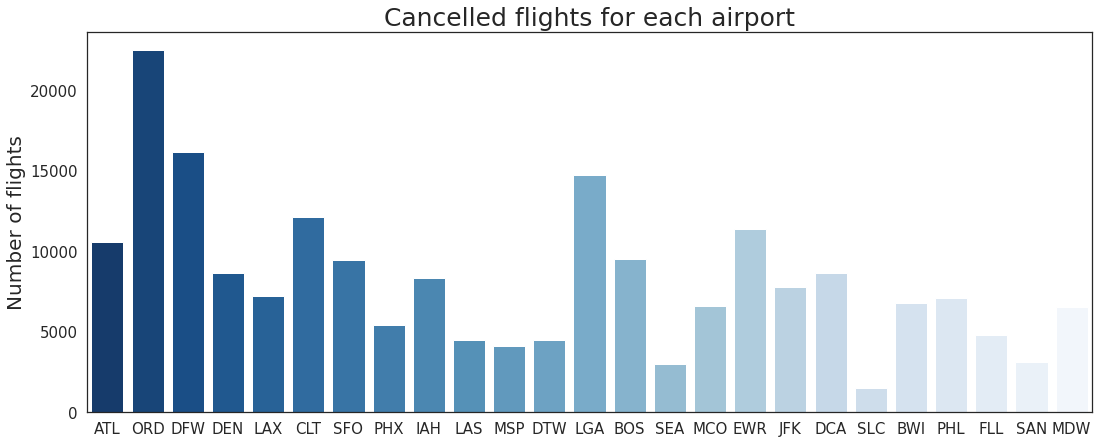

In [ ]:
rcParams['figure.figsize'] = 18,7
sns.set(style='white', rc={"grid.linewidth": 0.1})

ax = sns.countplot(x="DEST", data=cancelled_df[cancelled_df.DEST.isin(dest_vc['index'].to_list())], palette = "Blues_r", order = dest_vc['index'])
ax.axes.set_title("Cancelled flights for each airport",fontsize=25)
ax.set_xlabel("")
ax.set_ylabel("Number of flights",fontsize=20)
ax.tick_params(labelsize=15)

plt.savefig('canc_airport.png')

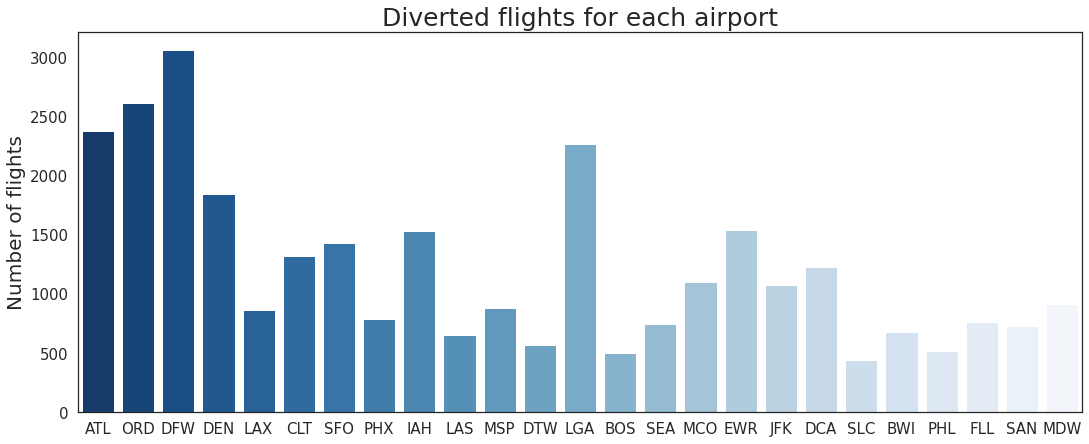

In [ ]:
rcParams['figure.figsize'] = 18,7
sns.set(style='white', rc={"grid.linewidth": 0.1})

ax = sns.countplot(x="DEST", data=diverted_df[diverted_df.DEST.isin(dest_vc['index'].to_list())], palette = "Blues_r", order = dest_vc['index'])
ax.axes.set_title("Diverted flights for each airport",fontsize=25)
ax.set_xlabel("")
ax.set_ylabel("Number of flights",fontsize=20)
ax.tick_params(labelsize=15)

plt.savefig('div_airport.png')

## Month

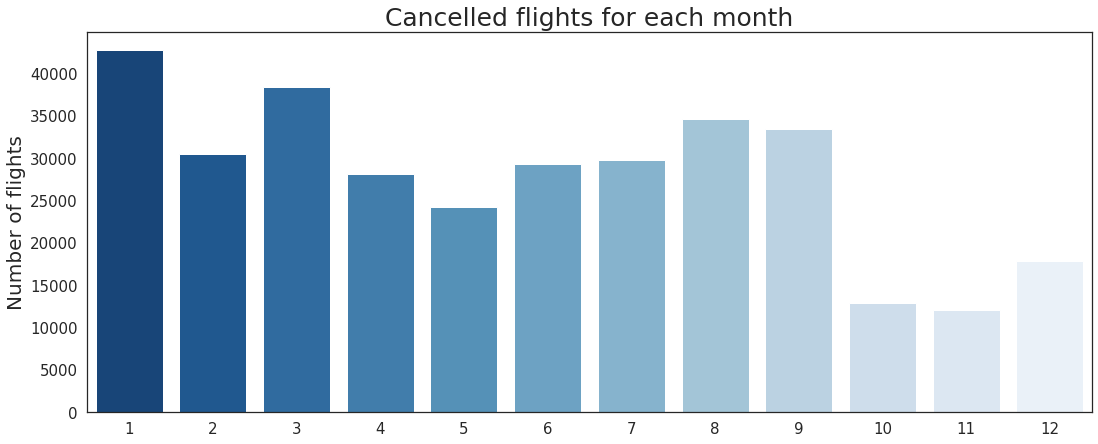

In [ ]:
rcParams['figure.figsize'] = 18,7
sns.set(style='white', rc={"grid.linewidth": 0.1})

ax = sns.countplot(x="month", data=cancelled_df, palette = "Blues_r")
ax.axes.set_title("Cancelled flights for each month",fontsize=25)
ax.set_xlabel("")
ax.set_ylabel("Number of flights",fontsize=20)
ax.tick_params(labelsize=15)

plt.savefig('canc_month.png')

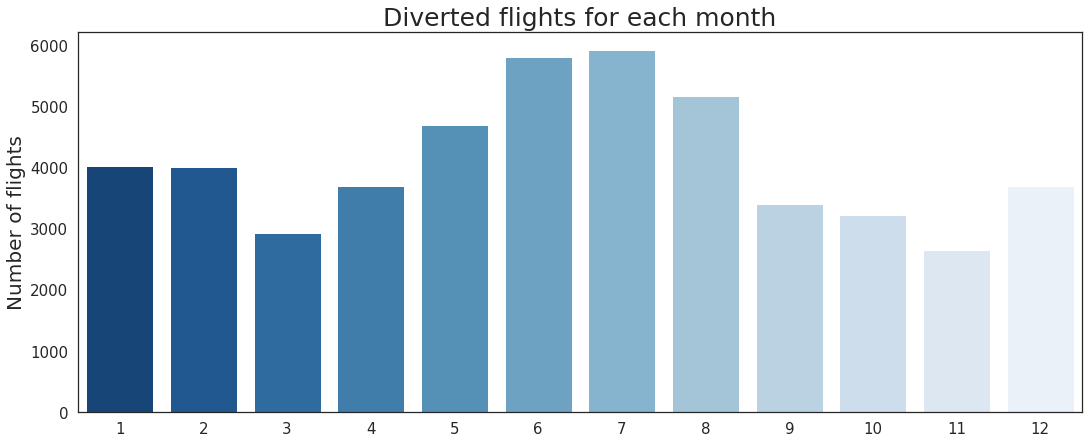

In [ ]:
rcParams['figure.figsize'] = 18,7
sns.set(style='white', rc={"grid.linewidth": 0.1})

ax = sns.countplot(x="month", data=diverted_df, palette = "Blues_r")
ax.axes.set_title("Diverted flights for each month",fontsize=25)
ax.set_xlabel("")
ax.set_ylabel("Number of flights",fontsize=20)
ax.tick_params(labelsize=15)

plt.savefig('div_month.png')

## Weekday

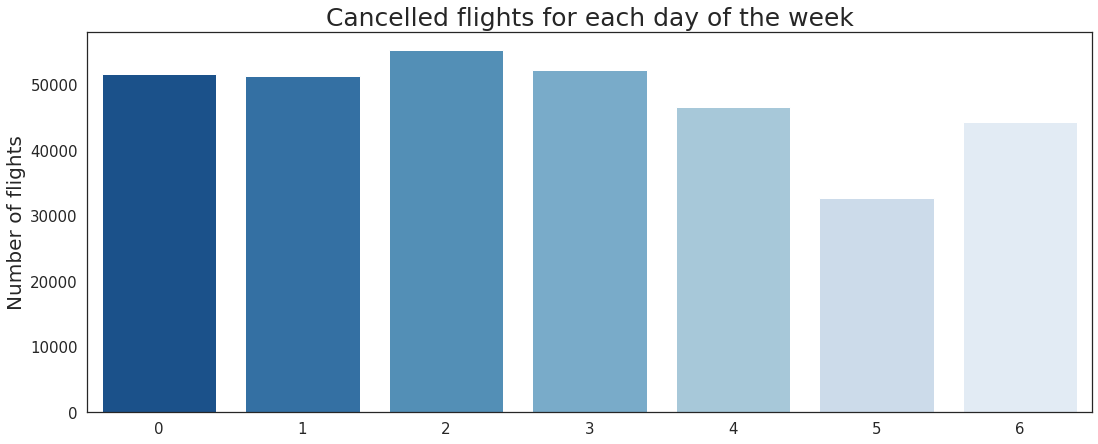

In [ ]:
rcParams['figure.figsize'] = 18,7
sns.set(style='white', rc={"grid.linewidth": 0.1})

ax = sns.countplot(x="weekday", data=cancelled_df, palette = "Blues_r")
ax.axes.set_title("Cancelled flights for each day of the week",fontsize=25)
ax.set_xlabel("")
ax.set_ylabel("Number of flights",fontsize=20)
ax.tick_params(labelsize=15)

plt.savefig('canc_weekday.png')

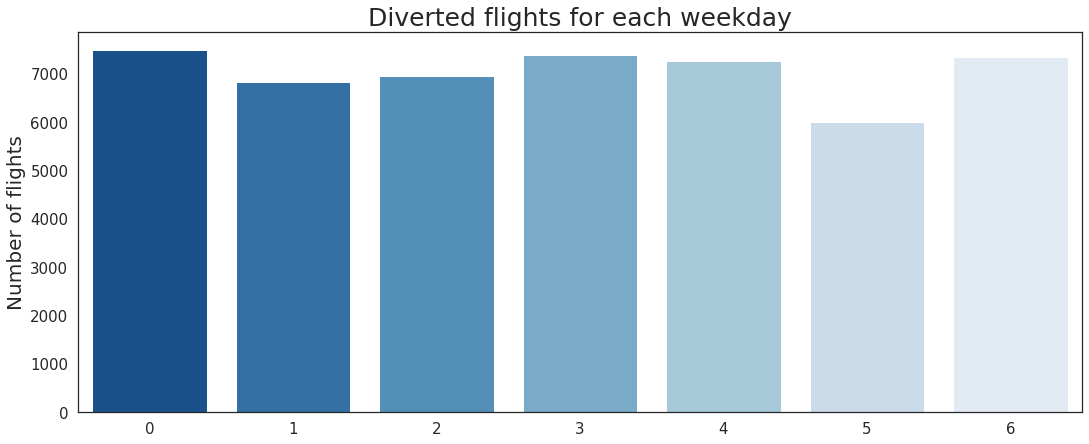

In [ ]:
rcParams['figure.figsize'] = 18,7
sns.set(style='white', rc={"grid.linewidth": 0.1})

ax = sns.countplot(x="weekday", data=diverted_df, palette = "Blues_r")
ax.axes.set_title("Diverted flights for each weekday",fontsize=25)
ax.set_xlabel("")
ax.set_ylabel("Number of flights",fontsize=20)
ax.tick_params(labelsize=15)

plt.savefig('div_weekday.png')